This code uses Recurrent Neural Network with Long-Short-Term Memory units, which takes lagged values as input.<br>
Additionally, we pass the **concept number** as a condition. Not dummy encoding because we don't know the total number of concepts in advance.<br>
The model is **trained only once** on the training dataset. <br>
For each new test point, we first perform the breakpoint detection and only then pass it to the algorithm for prediction.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input
from tqdm import tqdm
import time
from cond_rnn import ConditionalRNN
import csv
import tensorflow as tf
import functions

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [3]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(difference/summation)
    return error

Since now we can't use *ada_preprocessing()* to extract lagged values and concept, because it can potentially mess up breakpoint detection, we need separate function for this.

In [4]:
def manual_preprocessing(values, pattern):
    #receives the list of values up until and including the test point
    
    columns = list(pattern.columns)
    data = [values[-1], values[-2], values[-3], values[-4], values[-5], values[-6], pattern.loc[:,"concept"]]
    
    df = pd.DataFrame(columns=columns, data=[data])
    return df

Before using the model, some input preprocessing is due.

In [5]:
def forecast_preprocessing(train, test):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    test_X, test_y = test.iloc[:,1:], test.iloc[:,0]
    
    #separate both train and test sets into inputs and auxiliary variables
    train_X_input = train_X.loc[:,"t-1":"t-5"]
    train_X_aux = train_X.loc[:,"concept"]
    test_X_input = test_X.loc[:,"t-1":"t-5"]
    test_X_aux = test_X.loc[:,"concept"]
    
    #now also need to reshape X_input and X_aux
    X_arrays = np.asarray(train_X_input)
    train_X_input = np.hstack(X_arrays).reshape(train_X_input.shape[0], 1, train_X_input.shape[1])

    X_arrays = np.asarray(train_X_aux)
    train_X_aux = np.hstack(X_arrays).reshape(train_X_aux.shape[0], 1)
    
    #need to do the same for test set
    X_arrays = np.asarray(test_X_input)
    test_X_input = np.hstack(X_arrays).reshape(test_X_input.shape[0], 1, test_X_input.shape[1])

    X_arrays = np.asarray(test_X_aux)
    test_X_aux = np.hstack(X_arrays).reshape(test_X_aux.shape[0], 1)
    
    return train_X_input, train_X_aux, test_X_input, test_X_aux, train_y, test_y

*outputs = cond_rnn.ConditionalRNN(units=NUM_CELLS, cell='GRU')([inputs, cond])*

The conditional RNN expects those parameters:

*units*: int, The number of units in the RNN Cell. <br>
*cell*: string, cell class or object (pre-instantiated). In the case of string, 'GRU', 'LSTM' and 'RNN' are supported.<br>
*inputs*: 3-D Tensor with shape [batch_size, timesteps, input_dim].<br>
*cond*: 2-D Tensor or list of tensors with shape [batch_size, cond_dim]. In the case of a list, the tensors can have a different cond_dim.<br>
*\*args, \**kwargs*: Any parameters of the tf.keras.layers.RNN class, such as return_sequences, return_state, stateful, unroll...

In [6]:
def fit_cond_rnn(X_input, X_aux, train_y):
    inputs = Input(shape=(X_input.shape[1], X_input.shape[2]), dtype = tf.float32)
    cond1 = Input(shape = (X_aux.shape[1]), dtype = tf.float32)
    
    #building model steps
    A = ConditionalRNN(4, cell='LSTM')([inputs, cond1])
    out = Dense(1)(A)
    model = Model(inputs=[inputs, cond1], outputs=out)
    model.compile(loss = "mean_squared_error", optimizer = "adam")
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
    
    #fitting the model
    model.fit([X_input, X_aux], train_y, epochs = 50, batch_size = 1, callbacks = [es], verbose = 0, shuffle = False)
    
    return model

**Data Preprocessing.**

For numerical features, LSTMs expect data to be within the scale of the activation function.<br>
Since default activation function for LSTMs is *tanh*, we need to scale our values to be between -1 and 1, which is done by using MinMaxScaler.<br>
*The same min and max values should be used for both train and test sets to ensure the fairness of experiment.*

Conditional RNN model expectes inputs to be numerical time series values.<br>
The values that indicate the concept should be one-hot encoded and feed into the Conditional RNN as "condition".

The following function does one-hot encoding, scaling.

In [7]:
def preprocessing(data):
    #so far these columns didn't improve the analysis, so just drop them
    data.drop(["transition", "steps_to_bkp", "steps_since_bkp"], axis = 1, inplace = True)
    
    #scaling
    scaler_x = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t-1":"t-5"] = scaler_x.fit_transform(data.loc[:,"t-1":"t-5"])
    
    #need separate scaler only for target
    scaler_y = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t"] = scaler_y.fit_transform(np.asarray(data.loc[:,"t"]).reshape([-1,1]))
    
    return data, scaler_x, scaler_y

In [8]:
list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
                "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt"]

Time wasted: 0.81h
SMAPE: 0.7038


ValueError: x and y can be no greater than 2-D, but have shapes (240,) and (240, 1, 1)

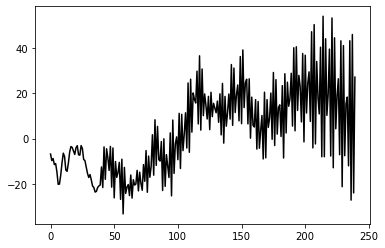

In [9]:
smape_dict = {}
error1 = []
error2 = []

for name in [list_of_names[0]]:
    file_path = "data/"+name+"_series"
    data = pd.read_csv(file_path).iloc[:,0].to_list()

    #70/30 train/test split
    split = int(0.7*len(data))
    train, test = data[:split], data[split:]
    
    predictions = []
    
    start = time.perf_counter()
    #need to perform the first step outside of the loop,
    #because we don't want to retrain our model each time
    
    #get breakpoints for train dataset
    history = functions.ada_preprocessing(train)
    #without the scaling for now
    history.drop(["transition", "steps_to_bkp", "steps_since_bkp"], axis = 1, inplace = True)

    #get the dataframe for new test observation
    train.append(test[0])
    test_df = manual_preprocessing(train, history.tail(1))
    
    #change train and test into form appropriate for CondRNN
    train_X_input, train_X_aux, test_X_input, test_X_aux, train_y, test_y = forecast_preprocessing(history, test_df)
    
    model = fit_cond_rnn(train_X_input, train_X_aux, train_y)
    
    #get predictions for new test observation
    prediction = model.predict([test_X_input, test_X_aux])
    predictions.append(prediction)
    
        
    #we've got the first prediction, so now start from 1
    for i in range(1, len(test)):
        #get breakpoints for train dataset
        history = functions.ada_preprocessing(train)
        
        history.drop(["transition", "steps_to_bkp", "steps_since_bkp"], axis = 1, inplace = True)
        
        #get the dataframe for new test observation
        train.append(test[i])
        test_row = manual_preprocessing(train, history.tail(1))
        
        #change train and test into form appropriate for CondRNN
        train_X_input, train_X_aux, test_X_input, test_X_aux, train_y, test_y = forecast_preprocessing(history, test_row)

        #get predictions for new test observation
        prediction = model.predict([test_X_input, test_X_aux])
        predictions.append(prediction)
        
        
    end = time.perf_counter()
    print("Time wasted: {:.2f}h".format((end-start)/3600))

    #inverting predictions to original scale
#     predictions = scaler.inverse_transform(np.asarray(predictions).reshape([-1,1]))

    error = smape(np.asarray(predictions), np.asarray(test))
    smape_dict[name] = error
    print("SMAPE: {:.4f}".format(error))
    
    plt.plot(test, label = "expected", color = "black")
    plt.plot(np.asarray(predictions).reshape([-1,1]), label = "predicted", color = "red")
    plt.title(name)
    plt.legend()
    plt.show()

Time wasted: 0.81h
SMAPE: 0.7038


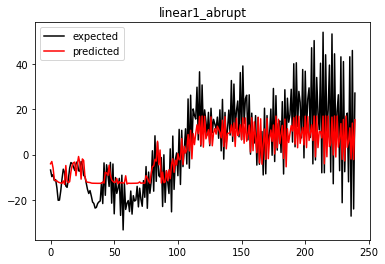

In [14]:
print("Time wasted: {:.2f}h".format((end-start)/3600))

    #inverting predictions to original scale
#     predictions = scaler.inverse_transform(np.asarray(predictions).reshape([-1,1]))

error = smape(np.asarray(predictions), np.asarray(test))
smape_dict[name] = error
print("SMAPE: {:.4f}".format(error))

plt.plot(test, label = "expected", color = "black")
plt.plot(np.asarray(predictions).reshape([-1,1]), label = "predicted", color = "red")
plt.title(name)
plt.legend()
plt.show()